In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch

from sparsecoding import inference
from sparsecoding import models
from sparsecoding.preprocess import patch_images, preprocess_images
from sparsecoding.visualization import plot_dictionary
from sparsecoding.visualization import plot_patches

### Define constants and load data

In [2]:
# your path here
img_dir = os.path.join(os.environ['DATA_PATH'],'data','IMAGES.mat')

images = loadmat(img_dir)['IMAGES']
images = torch.tensor(images)


In [3]:
n_images = images.shape[-1]
n_divisions = 32

image_data, n_images, n_divisions, patch_size_x, patch_size_y = patch_images(images, n_divisions=n_divisions)
data = preprocess_images(image_data, patch_size_x, patch_size_y)

n_samples, n_features = data.shape

### Visualize patches

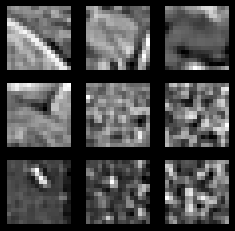

In [4]:
figure = plt.figure(figsize=(4,4))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img = (data[sample_idx])
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().reshape([patch_size_x,patch_size_y]), cmap="gray")
plt.show()

### Sparse Coding via Dictionary Learning

In [7]:
### DEFINE MODEL
ista = inference.ISTA(n_iter=100, sparsity_penalty=2e-1, stop_early=True)
sc = models.SparseCoding(inference_method=ista,n_basis=n_features,n_features=n_features,dictionary_lr=1e-1)

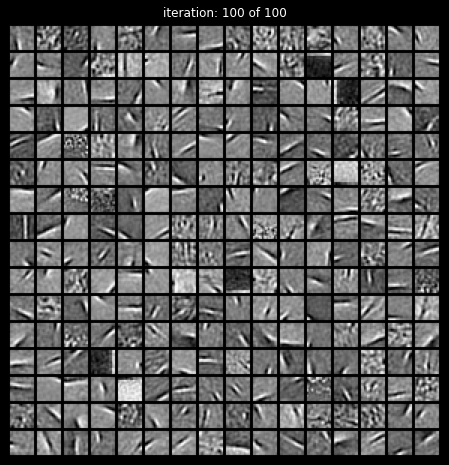

In [8]:
n_epoch = 100
montage_update_rate = 10
nrow = 16
fig,ax = plot_dictionary(sc.dictionary,nrow=nrow)
losses = np.array([])

# Learn dictionary (note learn_dictionary() includes inference).
for i in range(n_epoch//montage_update_rate):
    loss = sc.learn_dictionary(dataset=data,n_epoch=n_epoch,batch_size=500)
    losses = np.concatenate([losses,loss])

fig,ax = plot_dictionary(sc.dictionary,fig=fig,ax=ax,title='iteration: %d of %d'%(n_epoch,n_epoch),nrow=nrow)

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:title={'center':'data (100 of 10240)'}>)

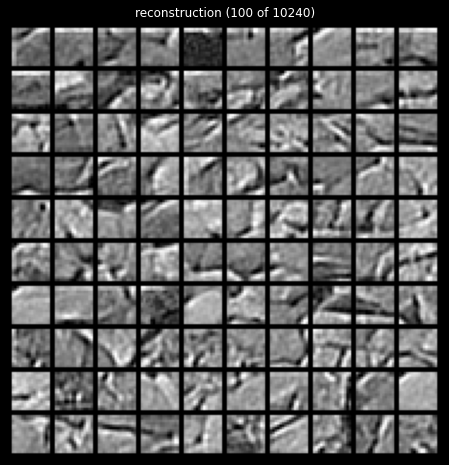

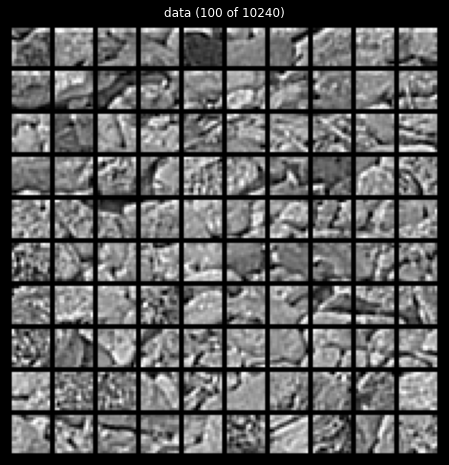

In [9]:
dictionary = torch.tensor(sc.get_numpy_dictionary().astype(np.float32))
a = ista.infer(data, dictionary)
ihat = torch.mm(dictionary, a.T).T
plot_patches(ihat[:100,:], title="reconstruction (100 of {})".format(data.shape[0]))
plot_patches(data[:100,:], title="data (100 of {})".format(data.shape[0]))

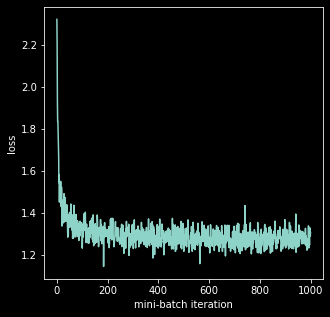

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(losses)
ax.set_xlabel('mini-batch iteration')
ax.set_ylabel('loss')
plt.show()

sparsity (total # of 0s/total # coefficients): 0.9396209716796875


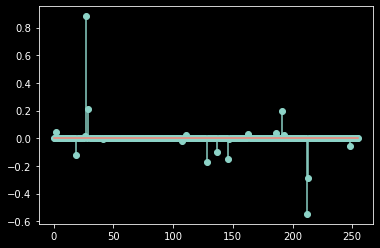

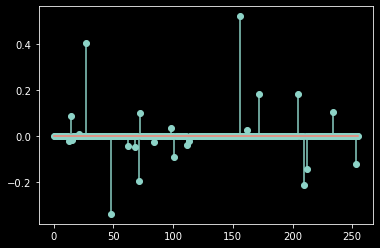

In [11]:
sparsity = np.sum(np.array(a) == 0 * 1)/np.array(a).size
print("sparsity (total # of 0s/total # coefficients): {}".format(sparsity))

plt.stem(a[1])
plt.show()

plt.stem(a[5])
plt.show()